In [214]:
# import necessary libraries
import os
from metaflow import FlowSpec, step
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import pandas as pd
import time


In [215]:
# Create the data directory if it doesn't exist
if not os.path.exists('data'):
    os.makedirs('data')

In [216]:
# Function to fetch data from OpenAQ API


def fetch_data(
        city: str, 
        start_date: str, 
        end_date: str, 
        limit: int, 
        retries=3
        ):
    '''
    Fetches air quality data by city from OpenAQ API.
    - Set params: 
        - City: array[string]
        - Start date / End date: datetime
        - number of retries: int
    - Get results
    - Returns a Pandas DataFrame
    Find out more about the API here:
    https://docs.openaq.org/docs/introduction
    '''
    url = f'https://api.openaq.org/v2/measurements'
    params = {
        'city': city,
        'date_from': start_date,
        'date_to': end_date,
        'limit': limit,
        'retries': retries
    }
    for attempt in range(retries):
        try:
            response = requests.get(url, params=params, timeout=10)  # Adjust timeout (seconds) as needed
            response.raise_for_status()  # Raise exception for HTTP errors
            data = response.json()['results']
            df = pd.DataFrame(data)
            
            filename = f'{city}_data.csv'
            df.to_csv(filename) # Output the raw data to csv
            
            return df

        except requests.exceptions.RequestException as e:
            print(f"Attempt {attempt + 1} failed: {e}")
            if attempt < retries - 1:
                print("Retrying...")
                time.sleep(1)  # Wait 1 second before retrying
            else:
                raise  # Raise exception if all retries fail
            
    # response = requests.get(url, params=params)
    # data = response.json()['results']
    
    # return pd.DataFrame(data)

**Here's a breakdown of the data queried from OpenAQ API:**

1. **Index (0)**: 
    
    Row index of dataset.

2. **SPARTAN - Melbourne**: 
    
    Were the measurement was taken, in this case a monitoring station in Melbourne.

3. **pm25**: *(parameter)*
    
    This indicates the pollutant being measured, specifically particulate matter with a diameter of 2.5 micrometers or smaller (PM2.5). PM2.5 is a measure of fine inhalable particles, about 20 - 30 times smaller than the diameter of the hair on your head. 

    These tiny particles are small enough to penetrate deep into the lungs, and even enter the bloodstream, causing various health problems, especially for people with pre-existing respiratory and cardiovascular conditions. 
    
    Long-term exposure to high levels of PM2.5 has been linked to increased risks of respiratory and cardiovascular diseases, as well as premature death.

4. **1.5**: *(value)*
    
    This is the measured concentration of PM2.5 in the units specified later (µg/m³).

5. **{'utc': '2023-06-19T17:00:00+00:00', 'local': '2023-06-20T03:00:00+10:00'}**: 
    
    Timestamps indicating when the measurement was recorded in both UTC (Coordinated Universal Time) and local time (UTC+10:00, which corresponds AEST).

6. **µg/m³**: *(unit)*
    
    Unit of measurement for PM2.5 concentration, micrograms per cubic meter.

7. **{'latitude': -37.7968, 'longitude': 144.963}**: 

    The geographical coordinates (latitude and longitude) of the measurement location in Melbourne, Australia.

8. **AU**: 
    
    Country code (ISO 3166-1 alpha-2 code) for Australia.

In [217]:
# Fetch data for specific city and date range
city = 'Melbourne'
start_date = '2021-01-01'
end_date = '2023-12-31'
limit = 12000
data = fetch_data(city, start_date, end_date, limit)

In [218]:
def clean_data(data: pd.DataFrame) -> pd.DataFrame:
    '''
    Cleans DataFrame containing air quality measurement data.
    
    See below for more info:
    
    - Select relevant columns for visualisations, training and prediction model 
        - date: AEST, 
        - value: float, 
        - unit: µg/m³ (micrograms per cubic meter)
        - parameter: PM25
    - Normalize 'date' column
    - Convert dates and assign
    - Pivot table pivots the DataFrame data so that:
        - Each unique 'date' becomes an index - AEST
        - Each unique 'parameter' becomes a column - PM2.5
        - The 'value' associated with each combination of 'date' and 'parameter' is placed in the corresponding cell of the pivoted DataFrame.
    - Resample to daily averages
    - Drop NaN values
    - Returns a DataFrame
    '''
    data = data[['date', 'value', 'unit', 'parameter']]
    
    # Normalize the nested 'date' dictionary to extract 'utc' values
    date_utc = pd.json_normalize(data['date'])['utc']

    # Convert the extracted 'utc' dates to pandas datetime objects and assign using .loc
    data.loc[:, 'date'] = pd.to_datetime(date_utc)
    data = data.pivot_table(index='date', columns='parameter', values='value')
    
    # Resample to daily averages
    data = data.resample('D').mean()
    
    data = data.dropna()
    
    return data



In [219]:
def plot_data(data):
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=data)
    plt.title('Daily Average AQI Levels')
    plt.xlabel('Date')
    plt.ylabel('AQI')
    plt.show()
    # Save the plot to the data directory
    plt.savefig('aqi_prediction.png')
    plt.close()



In [220]:
cleaned_data = clean_data(data)

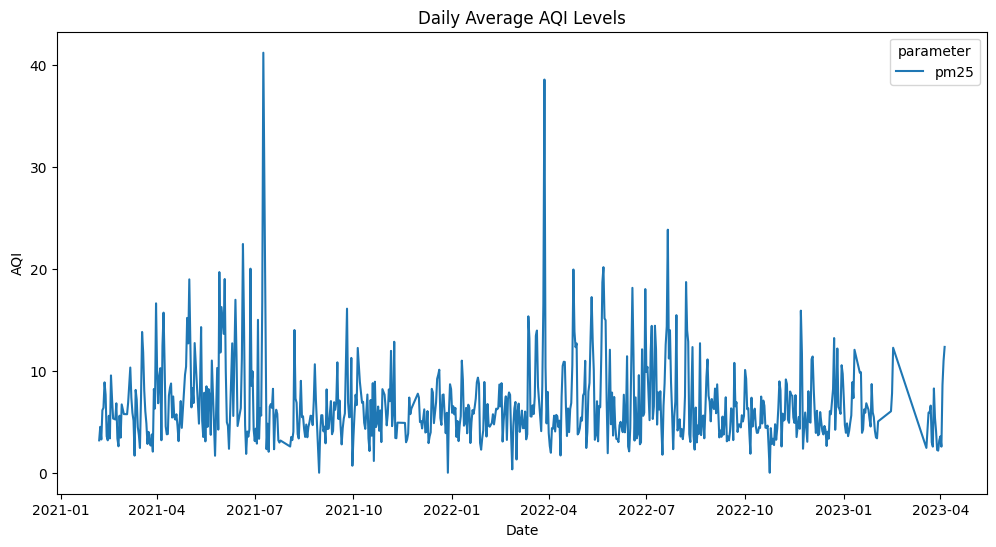

In [221]:
plot_data(cleaned_data)


# Training the model

In [222]:
def train_model(data):
    data['day_of_year'] = data.index.dayofyear
    X = data[['day_of_year']]
    y = data['pm25']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f'Mean Squared Error: {mse}')

    return model


model = train_model(cleaned_data)

Mean Squared Error: 34.09295958126563


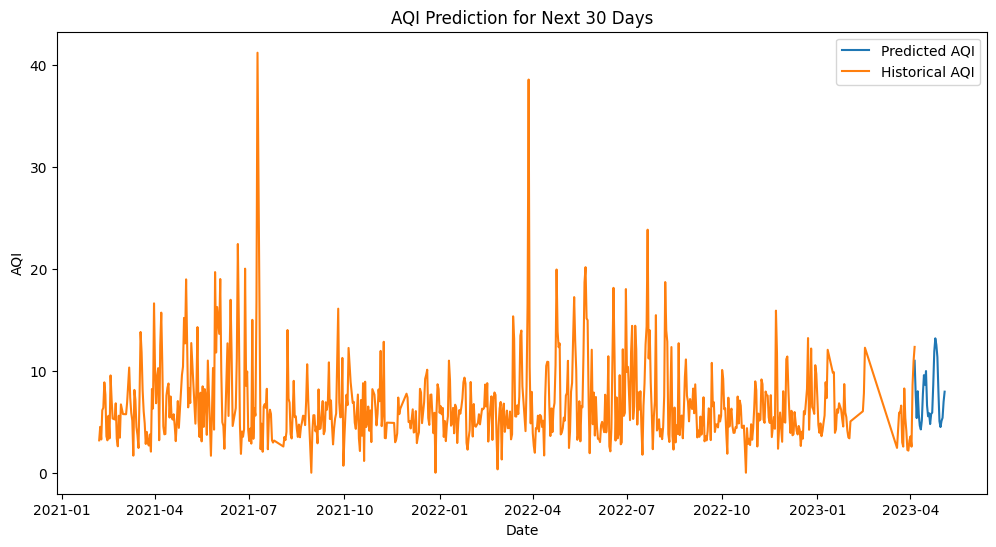

In [223]:
def predict_and_plot(model, data):
    future_dates = pd.date_range(start=data.index[-1], periods=30)
    future_data = pd.DataFrame(
        {'day_of_year': future_dates.dayofyear}, index=future_dates)
    predictions = model.predict(future_data)

    plt.figure(figsize=(12, 6))
    sns.lineplot(x=future_dates, y=predictions, label='Predicted AQI')
    sns.lineplot(data=data['pm25'], label='Historical AQI')
    plt.title('AQI Prediction for Next 30 Days')
    plt.xlabel('Date')
    plt.ylabel('AQI')
    plt.legend()
    plt.show()

    # Save the plot to the data directory
    plt.savefig('data/aqi_prediction.png')
    plt.close()


predict_and_plot(model, cleaned_data)

In [224]:

class AQIPredictionFlow(FlowSpec):

    @step
    def start(self):
        self.city = 'Melbourne'
        self.start_date = '2021-01-01'
        self.end_date = '2023-12-31'
        self.next(self.fetch_data)

    @step
    def fetch_data(self):
        self.data = fetch_data(self.city, self.start_date, self.end_date)
        self.next(self.clean_data)

    @step
    def clean_data(self):
        self.cleaned_data = clean_data(self.data)
        self.next(self.train_model)

    @step
    def train_model(self):
        self.model = train_model(self.cleaned_data)
        self.next(self.predict_and_plot)

    @step
    def predict_and_plot(self):
        predict_and_plot(self.model, self.cleaned_data)
        self.next(self.end)

    @step
    def end(self):
        print("AQI prediction pipeline complete.")